<a href="https://colab.research.google.com/github/Hamza-333/Image_Segmentation/blob/main/CSC420_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models, torchvision.datasets
from torch.utils.data import Dataset
from torchvision.io import read_image
import os
import shutil
import random
import matplotlib.pyplot as plt

# Data Preparation

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# !ls gdrive/MyDrive/CSC420_Final_Project/project3/project3/images

In [ ]:
example_clothing = read_image("/content/gdrive/MyDrive/CSC420_Final_Project/project3/project3/labels_clothing/0001_clothes.png")
example_person = read_image("/content/gdrive/MyDrive/CSC420_Final_Project/project3/project3/labels_person/0001_person.png")

In [ ]:
example_img = read_image("/content/gdrive/MyDrive/CSC420_Final_Project/project3/project3/images/0001.jpg")

In [ ]:
example_img.shape

torch.Size([3, 600, 400])

In [ ]:
example_img.float().mean()

tensor(148.8543)

In [ ]:
# Move images to validation and test folders
def move_images(num_imgs, dst_imgs_dir, dst_labels_c_dir, dst_labels_p_dir, src_imgs_dir, src_labels_c_dir, src_labels_p_dir):

    src_imgs = sorted(os.listdir(src_imgs_dir))
    src_c_labels = sorted(os.listdir(src_labels_c_dir))
    src_p_labels = sorted(os.listdir(src_labels_p_dir))
    if '.DS_Store' in src_imgs[0]:
        src_imgs = src_imgs[1:]
    if '.DS_Store' in src_c_labels[0]:
        src_c_labels = src_c_labels[1:]
    if '.DS_Store' in src_p_labels[0]:
        src_p_labels = src_p_labels[1:]

    if not os.path.exists(dst_imgs_dir):
        os.mkdir(dst_imgs_dir)
    if not os.path.exists(dst_labels_c_dir):
        os.mkdir(dst_labels_c_dir)
    if not os.path.exists(dst_labels_p_dir):
        os.mkdir(dst_labels_p_dir)

    random.seed(0)
    # print(random.sample(src_imgs, num_imgs))
    for img in random.sample(src_imgs, num_imgs):
        # move imgs and labels to destination folder
        src_imgs_path = os.path.join(src_imgs_dir, img)
        dst_imgs_path = os.path.join(dst_imgs_dir, img)
        shutil.move(src_imgs_path, dst_imgs_path)

    random.seed(0)
    # print(random.sample(src_c_labels, num_imgs))
    for img in random.sample(src_c_labels, num_imgs):
        src_labels_c_path = os.path.join(src_labels_c_dir, img)
        dst_labels_c_path = os.path.join(dst_labels_c_dir, img)
        shutil.move(src_labels_c_path, dst_labels_c_path)

    random.seed(0)
    # print(random.sample(src_p_labels, num_imgs))
    for img in random.sample(src_p_labels, num_imgs):
        src_labels_p_path = os.path.join(src_labels_p_dir, img)
        dst_labels_p_path = os.path.join(dst_labels_p_dir, img)
        shutil.move(src_labels_p_path, dst_labels_p_path)


In [ ]:
val_dest_imgs = "/content/gdrive/MyDrive/CSC420_Final_Project/project3/val_images/"
val_dest_c_labels = "/content/gdrive/MyDrive/CSC420_Final_Project/project3/val_labels_clothing/"
val_dest_p_labels = "/content/gdrive/MyDrive/CSC420_Final_Project/project3/val_labels_person/"

test_dest_imgs = "/content/gdrive/MyDrive/CSC420_Final_Project/project3/test_images/"
test_dest_c_labels = "/content/gdrive/MyDrive/CSC420_Final_Project/project3/test_labels_clothing/"
test_dest_p_labels = "/content/gdrive/MyDrive/CSC420_Final_Project/project3/test_labels_person/"

src_imgs = "/content/gdrive/MyDrive/CSC420_Final_Project/project3/images/"
src_c_labels = "/content/gdrive/MyDrive/CSC420_Final_Project/project3/labels_clothing/"
src_p_labels = "/content/gdrive/MyDrive/CSC420_Final_Project/project3/labels_person/"

In [ ]:
#example clothing label
print(example_clothing[0, 200, 200:])
plt.imshow(example_clothing[0])

In [ ]:
#example person label
print(example_person[0, 30, 100:])
plt.imshow(example_person[0])

In [ ]:
print(len(os.listdir("/content/gdrive/MyDrive/CSC420_Final_Project/project3/val_labels_clothing/")))

In [ ]:
import torch
from torchvision import transforms
import random

class RandomHorizontalFlip(object):
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, sample):
        img = sample['img']
        label = sample['label']
        if random.random() < self.p:

            img, label = img.flip(-1), label.flip(-1)  # flip both image and target
        return {'img': img, 'label': label}

class Normalize(torch.nn.Module):
    """Normalize a tensor image with mean and standard deviation.
    This transform does not support PIL Image.
    Given mean: ``(mean[1],...,mean[n])`` and std: ``(std[1],..,std[n])`` for ``n``
    channels, this transform will normalize each channel of the input
    ``torch.*Tensor`` i.e.,
    ``output[channel] = (input[channel] - mean[channel]) / std[channel]``

    .. note::
        This transform acts out of place, i.e., it does not mutate the input tensor.

    Args:
        mean (sequence): Sequence of means for each channel.
        std (sequence): Sequence of standard deviations for each channel.
        inplace(bool,optional): Bool to make this operation in-place.

    """

    def __init__(self, mean, std, inplace=False):
        super().__init__()
        self.mean = torch.tensor(mean, dtype=torch.float32)[None, :, None, None]
        self.std = torch.tensor(std, dtype=torch.float32)[None, :, None, None]
        self.inplace = inplace

    def forward(self, sample):
        """
        Args:
            tensor (Tensor): Tensor image to be normalized.

        Returns:
            Tensor: Normalized Tensor image.
        """
        img = sample['img']
        label = sample['label']
        img = img.float() / 255
        # print(img[0])
        img = (img - self.mean) / self.std
        return img, label

        # return transforms.functional.normalize(img, self.mean, self.std, self.inplace), label

In [ ]:
class SegmentationDataset(Dataset):
    def __init__(self, imgs_path, labels_path, num_classes, d_type):
        self.imgs_path = imgs_path
        self.imgs = sorted(os.listdir(imgs_path))

        if '.DS_Store' in self.imgs[0]:
            self.imgs = self.imgs[1:]
        self.labels_path = labels_path

        self.labels = sorted(os.listdir(labels_path))
        if '.DS_Store' in self.labels[0]:
            self.labels = self.labels[1:]
        self.num_classes = num_classes
        self.d_type = d_type
    def __getitem__(self, idx):
        """ Get image and its corresponding label """
        # img_p = os.path.join(self.imgs_path, )
        # print(os.path.join(self.imgs_path, self.imgs[idx]))
        img = read_image(os.path.join(self.imgs_path, self.imgs[idx]))
        # label_p = self.labels_path[idx]
        # print(os.path.join(self.labels_path, self.labels[idx]))

        label = read_image(os.path.join(self.labels_path, self.labels[idx]))
        # print(label.size())
        # img = torch.cat((1 - current_label, current_label), dim=1)
        # label = nn.functional.one_hot(label.long(), num_classes=self.num_classes)
        # label = label.permute(0, 3, 1, 2).squeeze(0)
        # one_hot_label = np.zeros((self.num_classes, label.shape[1], label.shape[2]))

        # for i, unique_value in enumerate(np.unique(label)):
        #   one_hot_label[i][label == unique_value] = 1
        # return (torch.tensor(img, dtype=torch.float32), torch.tensor(label, dtype=torch.float32))
        sample = {'img': torch.tensor(img, dtype=torch.float32), 'label':  torch.tensor(label, dtype=torch.float32)}
        return self.transform(sample)
    def transform(self, sample):
        if self.d_type == 'train':
            # Normalize Tensor: mean and std computed from training images
            transform = transforms.Compose([
                RandomHorizontalFlip(p=0.5),
                Normalize(mean=[0.3330, 0.3340, 0.3354], std=[0.2045, 0.2047, 0.2044])
])

        elif self.d_type == 'test' or self.d_type == 'val':
          # Normalize Tensor: mean and std computed from training images
            transform = transforms.Compose([
                Normalize(mean=[0.3330, 0.3340, 0.3354], std=[0.2045, 0.2047, 0.2044])
])


        return transform(sample)
    def __len__(self):
        return len(self.imgs)

In [ ]:
train_data_person = SegmentationDataset("/content/gdrive/MyDrive/CSC420_Final_Project/project3/project3/images/", "/content/gdrive/MyDrive/CSC420_Final_Project/project3/project3/labels_person/", num_classes=2, d_type='train')
train_data_clothing = SegmentationDataset("/content/gdrive/MyDrive/CSC420_Final_Project/project3/project3/images/", "/content/gdrive/MyDrive/CSC420_Final_Project/project3/project3/labels_clothing/", num_classes=7, d_type='train')

val_data_person = SegmentationDataset("/content/gdrive/MyDrive/CSC420_Final_Project/project3/project3/val_images/", "/content/gdrive/MyDrive/CSC420_Final_Project/project3/project3/val_labels_person/", num_classes=2, d_type='val')
val_data_clothing = SegmentationDataset("/content/gdrive/MyDrive/CSC420_Final_Project/project3/project3/val_images/", "/content/gdrive/MyDrive/CSC420_Final_Project/project3/project3/val_labels_clothing/", num_classes=7, d_type='val')

test_data_person = SegmentationDataset("/content/gdrive/MyDrive/CSC420_Final_Project/project3/project3/test_images/", "/content/gdrive/MyDrive/CSC420_Final_Project/project3/project3/test_labels_person/", num_classes=2, d_type='test')
test_data_clothing = SegmentationDataset("/content/gdrive/MyDrive/CSC420_Final_Project/project3/project3/test_images/", "/content/gdrive/MyDrive/CSC420_Final_Project/project3/project3/test_labels_clothing/", num_classes=7, d_type='test')

In [ ]:
data_length = len(train_data_person.imgs)
loader = torch.utils.data.DataLoader(train_data_person, batch_size=2, shuffle=True)
mean, std = 0, 0
for imgs, labels in loader:
  if torch.cuda.is_available():
      imgs = imgs.cuda()
      labels = labels.cuda()
  imgs = imgs.float() / 255
  imgs = imgs.view(data_length, imgs.size(1), -1)
  mean += imgs.mean(2).sum(0)
  std += imgs.std(2).sum(0)

  mean /= data_length
  std /= data_length


In [ ]:
print(data_length)

480


In [ ]:
print(mean)
print(std)

tensor([0.3330, 0.3340, 0.3354], device='cuda:0')
tensor([0.2045, 0.2047, 0.2044], device='cuda:0')


In [ ]:
len(sorted(os.listdir("/content/gdrive/MyDrive/CSC420_Final_Project/project3/labels_clothing/")))

In [ ]:
print(len(train_data_person.imgs))
print(len(train_data_clothing.imgs))
print(len(val_data_person.imgs))
print(len(val_data_clothing.imgs))
print(len(test_data_person.imgs))
print(len(test_data_clothing.imgs))

480
480
60
60
60
60


In [ ]:
print(train_data_clothing.__getitem__(12)[0][:, :, 200:, 300:])

tensor([[[[ 0.5769,  0.5961,  0.5961,  ...,  3.2616,  3.2616,  3.2616],
          [ 0.5769,  0.5961,  0.5961,  ...,  3.2616,  3.2616,  3.2616],
          [ 0.5769,  0.5961,  0.5961,  ...,  3.2616,  3.2616,  3.2616],
          ...,
          [ 1.5933,  1.6316,  1.6700,  ...,  3.2616,  3.2616,  3.2616],
          [ 1.5549,  1.6508,  1.6892,  ...,  3.2616,  3.2616,  3.2616],
          [ 1.6508,  1.7659,  1.8234,  ...,  3.2616,  3.2616,  3.2616]],

         [[ 0.5906,  0.6098,  0.6098,  ...,  3.2535,  3.2535,  3.2535],
          [ 0.5906,  0.6098,  0.6098,  ...,  3.2535,  3.2535,  3.2535],
          [ 0.5906,  0.6098,  0.6098,  ...,  3.2535,  3.2535,  3.2535],
          ...,
          [ 0.3416,  0.3799,  0.4182,  ...,  3.2535,  3.2535,  3.2535],
          [ 0.3033,  0.3991,  0.4374,  ...,  3.2535,  3.2535,  3.2535],
          [ 0.3991,  0.5140,  0.5715,  ...,  3.2535,  3.2535,  3.2535]],

         [[ 0.6806,  0.6998,  0.6998,  ...,  3.2515,  3.2515,  3.2515],
          [ 0.6806,  0.6998,  

<ipython-input-18-6161e1b73f02>:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample = {'img': torch.tensor(img, dtype=torch.float32), 'label':  torch.tensor(label, dtype=torch.float32)}


In [ ]:
print(val_data_clothing.__getitem__(12)[0].shape)

torch.Size([1, 3, 600, 400])


<ipython-input-18-6161e1b73f02>:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample = {'img': torch.tensor(img, dtype=torch.float32), 'label':  torch.tensor(label, dtype=torch.float32)}


In [ ]:
print(np.argmax(train_data_clothing.__getitem__(12)[1][:, 300, 154], keepdims=True))

tensor([1])


<ipython-input-4-71e154430c94>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return (torch.tensor(img, dtype=torch.float32), torch.tensor(label, dtype=torch.float32))


In [ ]:
train_data_clothing.__getitem__(1)[0]

# Resnet Model

In [ ]:
class ResidualBlockEncoder(nn.Module):
    expansion = 1
    def __init__(self, input_channels, out_channels, dilation, stride=1,
                 downsample=None):
        super(ResidualBlockEncoder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=input_channels, out_channels=out_channels,\
                           kernel_size=3, stride=stride, padding=dilation, dilation=dilation)

        self.norm1 = nn.BatchNorm2d(num_features=out_channels)
        # self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # 32 x 32 x 75 x 50
        self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels,\
                            kernel_size=3, stride=stride, padding=dilation, dilation=dilation)

        self.norm2 = nn.BatchNorm2d(num_features=out_channels)
        self.relu = nn.ReLU()
        self.downsample = downsample
    def forward(self, x):
        # print('Encoder')
        residual = x.clone()
        # print('Residual Before downsample:', residual.size())
        # print('X Before conv:', x.size())
        x = self.relu(self.norm1(self.conv1(x)))
        # print('X After conv1:', x.size())
        x = self.relu(self.norm2(self.conv2(x)))

        if self.downsample:
            residual = self.downsample(residual)

        # print('Residual After downsample:', residual.size())
        # print('X After conv:', x.size())
        x = x + residual
        x = self.relu(x)

        return x


In [ ]:
class ResNetEncoder(nn.Module):
    def __init__(self, num_blocks, ResidualBlock, dilations, img_channels=3,
                 out_channels=16):
        super(ResNetEncoder, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=img_channels, out_channels=out_channels,\
                           kernel_size=7, stride=2, padding=1)
        self.norm1 = nn.BatchNorm2d(num_features=out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.layer_in_channels = out_channels
        self.layer1 = self._make_layer(ResidualBlock, num_blocks[0], dilations[0], out_channels=32)
        self.layer2 = self._make_layer(ResidualBlock, num_blocks[1], dilations[1], out_channels=64, stride=1)
        self.layer3 = self._make_layer(ResidualBlock, num_blocks[2], dilations[2], out_channels=128, stride=1)
        self.layer4 = self._make_layer(ResidualBlock, num_blocks[3], dilations[3], out_channels=256, stride=1)

        self.relu = nn.ReLU()

    def _make_layer(self, ResidualBlock, num_blocks, dilation, out_channels, stride=1):
        downsample = None
        if stride != 1 or self.layer_in_channels != out_channels * ResidualBlock.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.layer_in_channels, out_channels * ResidualBlock.expansion, stride=stride, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_channels * ResidualBlock.expansion)
            )

        layer = []
        layer.append(ResidualBlock(self.layer_in_channels, out_channels, dilation, stride, downsample))
        self.layer_in_channels = out_channels * ResidualBlock.expansion

        for i in range(1, num_blocks):
            layer.append(ResidualBlock(self.layer_in_channels, out_channels, dilation, stride))

        return nn.Sequential(*layer)

    def forward(self, x):

        x = self.relu(self.norm1(self.conv1(x)))
        x = self.layer1(x)
        # p1_shape = x.shape
        x_1 = x.clone()
        # x, ind_1 = self.pool(x)
        # x, ind_2 = self.pool(x)
        x = self.layer2(x)
        # p2_shape = x.shape
        x_2 = x.clone()
        # x, ind_2 = self.pool(x)

        x = self.layer3(x)
        # p3_shape = x.shape
        x_3 = x.clone()
        # x, ind_3 = self.pool(x)
        # x, ind_4 = self.pool(x)
        x = self.layer4(x)
        p4_shape = x.shape
        x_4 = x.clone()
        x, ind_4 = self.pool(x)
        # x, ind_5 = self.pool(x)
        clones = [x_1, x_2, x_3, x_4]
        # return x, ind_1, ind_2, ind_3, ind_4, ind_5
        # return x, ind_1, ind_2, ind_3, ind_4, p1_shape, p2_shape, p3_shape, p4_shape, clones
        # return x, ind_2, ind_4, p2_shape, p4_shape, clones
        return x, ind_4, p4_shape, clones

In [ ]:
class ResidualBlockDecoder(nn.Module):
    expansion = 1
    def __init__(self, input_channels, out_channels, dilation, stride=1,
                 upsample=None):
        super(ResidualBlockDecoder, self).__init__()
        self.t_conv1 = nn.ConvTranspose2d(in_channels=input_channels, out_channels=out_channels,\
                           kernel_size=3, stride=stride, output_padding=0, dilation=dilation, padding=dilation)

        self.norm1 = nn.BatchNorm2d(num_features=out_channels)
        # self.pool = nn.MaxPool2d(kernel_size=2, stride=2)


        self.t_conv2 = nn.ConvTranspose2d(in_channels=out_channels, out_channels=out_channels,\
                            kernel_size=3, stride=stride, output_padding=0, dilation=dilation, padding=dilation)

        self.norm2 = nn.BatchNorm2d(num_features=out_channels)
        self.relu = nn.ReLU()
        self.upsample = upsample
    def forward(self, x):
        # print('Decoder')
        residual = x.clone()
        # print('Residual Before upsample:', residual.size())
        # print('X Before conv:', x.size())
        x = self.relu(self.norm1(self.t_conv1(x)))
        # print('X After conv1:', x.size())
        x = self.relu(self.norm2(self.t_conv2(x)))

        if self.upsample:
            residual = self.upsample(residual)

        # print('Residual After upsample:', residual.size())
        # print('X After conv:', x.size())
        x = x + residual
        x = self.relu(x)

        return x


In [ ]:
class ResNetDecoder(nn.Module):
    def __init__(self, num_blocks, ResidualBlock, dilations, num_classes,
                 encoder_out_channels=256, layer4_out_channels=16):
        super(ResNetDecoder, self).__init__()
        self.layer_in_channels = encoder_out_channels

        self.layer1 = self._make_layer(ResidualBlock, num_blocks[3], dilations[3], out_channels=128)
        self.layer2 = self._make_layer(ResidualBlock, num_blocks[2], dilations[2], out_channels=64, stride=1)
        self.layer3 = self._make_layer(ResidualBlock, num_blocks[1], dilations[1], out_channels=32, stride=1)
        self.layer4 = self._make_layer(ResidualBlock, num_blocks[0], dilations[0], out_channels=16, stride=1)

        self.t_conv = nn.ConvTranspose2d(in_channels=layer4_out_channels, out_channels=num_classes,\
                    kernel_size=7, stride=2, padding=1, output_padding=1)
        self.norm1 = nn.BatchNorm2d(num_features=num_classes)
        self.unpool = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()


    def _make_layer(self, ResidualBlock, num_blocks, dilation, out_channels, stride=1):
        upsample = None
        if stride != 1 or self.layer_in_channels != out_channels * ResidualBlock.expansion:
            upsample = nn.Sequential(
                nn.ConvTranspose2d(self.layer_in_channels * 2, out_channels * ResidualBlock.expansion, stride=stride, kernel_size=1),
                nn.BatchNorm2d(out_channels * ResidualBlock.expansion),
            )

        layer = []
        layer.append(ResidualBlock(self.layer_in_channels * 2, out_channels, dilation, stride, upsample))
        self.layer_in_channels = out_channels * ResidualBlock.expansion

        for i in range(1, num_blocks):
            layer.append(ResidualBlock(self.layer_in_channels, out_channels, dilation, stride))

        return nn.Sequential(*layer)

    # def forward(self, x, ind_1, ind_2, ind_3, ind_4, ind_5):
    # def forward(self, x, ind_1, ind_2, ind_3, ind_4, p1_shape, p2_shape, p3_shape, p4_shape, clones):
    # def forward(self, x, ind_1, ind_2, ind_3, ind_4, p1_shape, p2_shape, p3_shape, p4_shape, clones):
    # def forward(self, x, ind_2, ind_4, p2_shape, p4_shape, clones):
    def forward(self, x, ind_4, p4_shape, clones):
        # print(x.shape)
        x = self.unpool(x, ind_4, output_size=p4_shape)
        x = torch.cat((x, clones[3]), dim=1)
        # print(x.shape)
        x = self.layer1(x)
        # print("hello")
        # x = self.unpool(x, ind_5)
        # x = self.unpool(x, ind_3, output_size=p3_shape)
        x = torch.cat((x, clones[2]), dim=1)
        x = self.layer2(x)
        # x = self.unpool(x, ind_2, output_size=p2_shape)
        x = torch.cat((x, clones[1]), dim=1)
        x = self.layer3(x)
        # x = self.unpool(x, ind_1, output_size=p1_shape)
        x = torch.cat((x, clones[0]), dim=1)
        # x = self.unpool(x, ind_3)
        x = self.layer4(x)
        # x = self.unpool(x, ind_2)
        # print('AFTER LAYER4 DECODER:', x.size())
        x = self.relu(self.norm1(self.t_conv(x)))
        # print('AFTER LAST CONV DECODER:', x.size())
        # x = self.unpool(x, ind_1, output_size=pool1_shape)



        return x

In [ ]:
class ImageSegmentation(nn.Module):
    def __init__(self, num_blocks, dilations, task):
        super(ImageSegmentation, self).__init__()
        num_classes = 7 if task == 'clothing' else 2
        self.encoder = ResNetEncoder(num_blocks, ResidualBlockEncoder, dilations, img_channels=3)
        self.decoder = ResNetDecoder(num_blocks, ResidualBlockDecoder, dilations,
                                     encoder_out_channels=256, layer4_out_channels=16, num_classes=num_classes)
        # self.pool = nn.AdaptiveAvgPool2d(None)

    def forward(self, x):

        # x, ind_1, ind_2, ind_3, ind_4, ind_5 = self.encoder(x)
        # x, ind_1, ind_2, ind_3, ind_4, p1_shape, p2_shape, p3_shape, p4_shape, clones = self.encoder(x)
        # x, ind_2, ind_4, p2_shape, p4_shape, clones = self.encoder(x)
        x, ind_4, p4_shape, clones = self.encoder(x)
        # print('AFTER ENCODER: ', x.size())
        # x = self.pool(x)
        # x = self.decoder(x, ind_1, ind_2, ind_3, ind_4, ind_5)
        # x = self.decoder(x, ind_1, ind_2, ind_3, ind_4, p1_shape, p2_shape, p3_shape, p4_shape, clones)
        # x = self.decoder(x, ind_2, ind_4, p2_shape, p4_shape, clones)
        x = self.decoder(x, ind_4, p4_shape, clones)
        return x
    def save(self, path):
        torch.save(self.encoder.state_dict(), '{}_encoder.pk'.format(path))
        torch.save(self.decoder.state_dict(), '{}_decoder.pk'.format(path))

    def load(self, path):
        self.encoder.load_state_dict(torch.load(self.encoder.state_dict(), '{}_encoder.pk'.format(path)))
        self.decoder.load_state_dict(torch.load(self.decoder.state_dict(), '{}_decoder.pk'.format(path)))

In [ ]:
!pip install torchmetrics

In [ ]:
from torchmetrics import JaccardIndex

In [ ]:
def get_accuracy(model, data, num_classes):
    # note: why should we use a larger batch size here?
    # We do not need to compute paramater updates, thus a smaller batch size is
    # not advantageous. A larger batch size will reduce number of iterations
    # and would allow for more parallel computations. Therefore, it would be
    # faster.
    loader = torch.utils.data.DataLoader(data, batch_size=1, shuffle=True)

    model.eval() # annotate model for evaluation (why do we need to do this?)
    # some layers act differently in training vs testing, e.g: BatchNorm,
    # Dropout. Need to "turn them off" when calculating accuracy.
    correct = 0
    total = 0
    N = 0
    accs_list = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    jaccard = JaccardIndex(task="multiclass", num_classes=num_classes).to(device)
    iou_list = []
    # print((loader))
    if torch.cuda.is_available():
        model.cuda()
    i = 0
    for imgs, labels in loader:
        imgs = imgs.squeeze(1)
        if torch.cuda.is_available():
            imgs = imgs.cuda()
            labels = labels.cuda()
        output = model(imgs)

        pred = output.argmax(1, keepdim=True)

        # print("IOU:", iou)
        correct = pred.eq(labels.view_as(pred)).sum().item()
        # print(labels.shape)
        # target = nn.functional.one_hot(labels.long(), num_classes=num_classes)
        # # print(target.shape)
        # target = target.permute(0, 4, 2, 3, 1).squeeze(4)
        # print(target.shape)
        iou = jaccard(pred, labels)
        iou_list.append(iou)
        # print(correct)
        # print((imgs.shape))
        acc = correct / (imgs.shape[2] * imgs.shape[3] * imgs.shape[0])
        accs_list.append(acc)

        i += 1
        if i == 1:
          print("Prediction", np.unique(pred.cpu().numpy(), return_counts=True))
          print("Target", np.unique(labels.cpu().numpy(), return_counts=True))
        del imgs
        del labels
        del output
        del pred
        torch.cuda.empty_cache()
    # print(sum(accs_list)/len(accs_list))
    return sum(accs_list)/len(accs_list), sum(iou_list) / len(iou_list)

In [ ]:
def iou_metric(model, data, num_classes):
    loader = torch.utils.data.DataLoader(data, batch_size=2)

    model.eval() # annotate model for evaluation (why do we need to do this?)
    # some layers act differently in training vs testing, e.g: BatchNorm,
    # Dropout. Need to "turn them off" when calculating accuracy.
    correct = 0
    total = 0
    N = 0
    # print((loader))
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    jaccard = JaccardIndex(task="multiclass", num_classes=num_classes).to(device)
    iou_list = []
    if torch.cuda.is_available():
        model.cuda()
    for imgs, labels in loader:
        imgs = imgs.squeeze(1)
        if torch.cuda.is_available():
            imgs = imgs.cuda()
            labels = labels.cuda()
        output = model(imgs)

        pred = output.argmax(1, keepdim=True)[1]
        target = labels.argmax(1, keepdim=True)[1]
        iou = jaccard(pred, target)
        # print("IOU:", iou)
        iou_list.append(iou)
        # print(iou)
    # Compute the mean over the batch dimension.
    # print("IOU_LIST:", sum(iou_list)/len(iou_list))
    return sum(iou_list) / len(iou_list)

In [ ]:
class IoULoss(nn.Module):
    def __init__(self, num_classes, weight=None):
        super(IoULoss, self).__init__()
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.jaccard = JaccardIndex(task="multiclass", num_classes=num_classes).to(device)
    def forward(self, outputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        # inputs = F.sigmoid(inputs)
        pred = nn.functional.softmax(outputs, dim=1)
        # #flatten label and prediction tensors
        pred = pred.view(-1)
        targets = targets.view(-1)

        #intersection is equivalent to True Positive count
        #union is the mutually inclusive area of all labels & predictions
        intersection = (pred * targets).sum()
        total = (pred + targets).sum()
        union = total - intersection

        IoU = (intersection + smooth)/(union + smooth)

        # IoU = self.jaccard(pred, targets)

        return 1 - IoU

In [ ]:
!pip install git+https://github.com/qubvel/segmentation_models.pytorch

In [ ]:
from segmentation_models_pytorch.losses import TverskyLoss

In [ ]:
def train(train_data, valid_data, model, checkpoint_path, checkpoint_dir, num_classes, num_epochs=50, learning_rate=1e-3, batch_size=32,
          weight_decay=0):
    train = torch.utils.data.DataLoader(train_data, batch_size=batch_size,\
                                        shuffle=True)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    class_weights = torch.tensor([1, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0]).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    # criterion = TverskyLoss(mode='multiclass', classes=7, from_logits=True, log_loss=True, gamma=0.75, alpha=0.75)
    # criterion = IoULoss(num_classes=num_classes)
    if not os.path.exists(checkpoint_dir):
        os.mkdir(checkpoint_dir)
    epoch = 0
    train_accs, train_losses = [], []
    val_accs = []
    iters = []
    n = 0
    epochs = []
    val_ious = []
    train_ious = []
    batch_loss = 0
    # model = model.half()
    if torch.cuda.is_available():
        model.cuda()
        criterion.cuda()
    # get_accuracy(model, valid_data)
    # iou_metric(model, valid_data, num_classes)
    # jaccard = JaccardIndex(task="multiclass", num_classes=num_classes).to(device)
    while epoch < num_epochs:
        learning_rate = learning_rate
        optimizer = optim.Adam(model.parameters(),
                lr=learning_rate,
                weight_decay=weight_decay)
        model.train()
        for imgs, labels in train:
            epoch_loss = 0
            imgs = imgs.squeeze(1)
            if imgs.shape[0] < batch_size:
                # Last batch will have less images since it will be the
                # remainder of Total images / batch_size.

                # Adjust the learning rate of the last batch by
                # (size(last_batch) / batch_size) to account
                # for the smaller size.

                # learning_rate = learning_rate * (imgs.shape[0] / batch_size)
                optimizer = optim.Adam(model.parameters(),
                                        lr=learning_rate * (imgs.shape[0] / batch_size),
                                        weight_decay=weight_decay)
            if torch.cuda.is_available():
                imgs = imgs.cuda()
                # labels = labels.cuda()
            # imgs = imgs.half()
            outputs = model(imgs).float()
            labels = labels.squeeze(dim=1).long()

            if torch.cuda.is_available():
                outputs = outputs.cuda()
                # labels = labels.cuda()
            # pred = nn.functional.softmax(outputs, dim=1)
            # target = torch.argmax(labels, dim=1).float()
            # print(outputs.shape)
            # outputs = torch.argmax(outputs, dim=1).float()

            # loss = criterion(outputs, labels.cuda())
            # loss = 1 - jaccard(pred.to(device), labels.to(device))
            loss = criterion(outputs, labels.cuda())
            # print(loss)
            loss.backward()
            if n % 8:
              optimizer.step()
              optimizer.zero_grad()

            n += 1
            # print(n)
            iters.append(n)
            # average loss
            train_losses.append(float(loss)/batch_size)
            epoch_loss += float(loss)
            del imgs
            del labels
            del outputs
            torch.cuda.empty_cache()
            # break
            # break
        # end of epoch
        epoch += 1
        epochs.append(epoch)
        # train_acc, train_iou = get_accuracy(model, train_data, num_classes)
        # train_accs.append(train_acc)
        # train_iou = iou_metric(model, train_data, num_classes)
        # train_ious.append(train_iou)


        val_acc, val_iou = get_accuracy(model, valid_data, num_classes)
        val_accs.append(val_acc)
        # val_iou = iou_metric(model, valid_data, num_classes)
        val_ious.append(val_iou)
        if epoch % 10 == 0 and learning_rate > 1e-4:
          learning_rate = 1e-4
        # if epoch % 10 == 0 and learning_rate > 1e-5:
        #   learning_rate /= 10
        # print("--------------------------------------------------------------")
        # # print("Epochs: {}   Train Accuracy: {}   Train IOU: {}   Val Accuracy: {}   Val IOU: {}   Epoch Loss: {}   LR: {}".format(epoch, train_acc, train_iou, val_acc, val_iou, epoch_loss, learning_rate))
        # print("--------------------------------------------------------------")

        print("--------------------------------------------------------------")
        print("Epochs: {}   Val Accuracy: {}   Val IOU: {}   Epoch Loss: {}   LR: {}".format(epoch, val_acc, val_iou, epoch_loss, learning_rate))
        print("--------------------------------------------------------------")
        # print("Epochs: {}   Val Accuracy: {}".format(epoch, val_acc))

        # checkpoint_path = '/content/gdrive/My Drive/CSC420/A2/ckpt-{}.pk'

        # torch.save(model.state_dict(), checkpoint_path.format(epoch))
        if epoch > 15:
          model.save(checkpoint_path.format(epoch))
    return iters, train_losses, epochs, train_accs, val_accs, train_ious, val_ious


In [ ]:
person_checkpoint_path = "/content/gdrive/MyDrive/CSC420_Final_Project/project3/project3/checkpoints/person_checkpoint/checkpoint-{}"
clothing_checkpoint_path= "/content/gdrive/MyDrive/CSC420_Final_Project/project3/project3/checkpoints/clothing_checkpoint/checkpoint-{}"

In [ ]:
person_checkpoint_dir = "/content/gdrive/MyDrive/CSC420_Final_Project/project3/project3/checkpoints/person_checkpoint"
clothing_checkpoint_dir= "/content/gdrive/MyDrive/CSC420_Final_Project/project3/project3/checkpoints/clothing_checkpoint"

In [ ]:
img_size = train_data_person.__getitem__(1)[1].size()
num_blocks = [4, 8, 16, 12]
# num_blocks = [1, 1, 1, 1]
dilations = [1, 1, 2, 2]

<ipython-input-5-6161e1b73f02>:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample = {'img': torch.tensor(img, dtype=torch.float32), 'label':  torch.tensor(label, dtype=torch.float32)}


In [ ]:
task = 'person'
model = ImageSegmentation(num_blocks=num_blocks, dilations=dilations, task=task)

In [ ]:
print(len(test_data_person.imgs))

In [ ]:
iters, train_losses, epochs, train_accs, val_accs, train_ious, val_ious = train(train_data_person,
                                                          val_data_person, model,
                                                          num_epochs=50,
                                                          learning_rate=1e-3,
                                                          batch_size=16,
                                                          weight_decay=0,
                                                          checkpoint_path=person_checkpoint_path,
                                                          checkpoint_dir=person_checkpoint_dir,
                                                          num_classes=2)

In [ ]:
def get_accuracy2(model, data):
    # note: why should we use a larger batch size here?
    # We do not need to compute paramater updates, thus a smaller batch size is
    # not advantageous. A larger batch size will reduce number of iterations
    # and would allow for more parallel computations. Therefore, it would be
    # faster.
    loader = torch.utils.data.DataLoader(data, batch_size=1, shuffle=True)

    model.eval() # annotate model for evaluation (why do we need to do this?)
    # some layers act differently in training vs testing, e.g: BatchNorm,
    # Dropout. Need to "turn them off" when calculating accuracy.
    correct = 0
    total = 0
    N = 0
    # print((loader))
    if torch.cuda.is_available():
        model.cuda()
    i = 0
    colors = ['black','green', 'blue', 'purple', 'pink', 'orange', 'yellow']
    for imgs, labels in loader:
        imgs = imgs.squeeze(1)
        if torch.cuda.is_available():
            imgs = imgs.cuda()
            labels = labels.cuda()
        output = model(imgs)
        # print(pred.shape)
        pred = output.argmax(1, keepdim=True)
        # target = labels.argmax(1, keepdim=True)
        print(pred.shape)
        i += 1
        plt.imshow(pred.cpu()[0, 0, :, :])
        plt.show()
        plt.imshow(labels.cpu()[0, 0, :, :])
        # print(pred.shape)
        print(pred[:, :, 200:-200, 200:-150])
        print(labels[:, :, 200:-200, 200:-150])
        plt.show()
        del imgs
        del labels
        del output
        torch.cuda.empty_cache()
        if i == 3:
          break
    return pred, labels # TODO: return the model accuracy

In [ ]:
task = 'clothing'
model = ImageSegmentation(num_blocks=num_blocks, dilations=dilations, task=task)

In [ ]:
clothing_checkpoint_path= "/content/gdrive/MyDrive/CSC420_Final_Project/project3/project3/checkpoints/clothing_checkpoint/checkpoint-1-1-2-2-dial-4-8-16-12-blocks-1-max{}"

In [ ]:
iters, train_losses, epochs, train_accs, val_accs, train_ious, val_ious = train(train_data_clothing,
                                                          val_data_clothing, model,
                                                          num_epochs=50,
                                                          learning_rate=0.0005,
                                                          batch_size=2,
                                                          weight_decay=0,
                                                          checkpoint_path=clothing_checkpoint_path,
                                                          checkpoint_dir=clothing_checkpoint_dir,
                                                          num_classes=7)

<ipython-input-5-6161e1b73f02>:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample = {'img': torch.tensor(img, dtype=torch.float32), 'label':  torch.tensor(label, dtype=torch.float32)}


In [ ]:
read_image('/content/gdrive/MyDrive/CSC420_Final_Project/project3/project3/images/0438.jpg')

tensor([[[109, 109, 109,  ..., 115, 120, 121],
         [107, 107, 107,  ..., 115, 121, 122],
         [106, 106, 106,  ..., 112, 118, 118],
         ...,
         [210, 205, 202,  ..., 228, 230, 232],
         [203, 206, 208,  ..., 226, 228, 230],
         [216, 212, 209,  ..., 225, 227, 228]],

        [[170, 170, 170,  ..., 123, 128, 129],
         [172, 172, 172,  ..., 123, 129, 130],
         [174, 174, 174,  ..., 121, 127, 127],
         ...,
         [215, 210, 207,  ..., 215, 217, 219],
         [206, 209, 211,  ..., 213, 215, 217],
         [219, 215, 209,  ..., 212, 214, 215]],

        [[255, 255, 255,  ..., 136, 141, 142],
         [255, 255, 255,  ..., 136, 142, 143],
         [247, 247, 247,  ..., 136, 142, 142],
         ...,
         [221, 216, 213,  ..., 207, 209, 211],
         [213, 216, 218,  ..., 205, 207, 209],
         [226, 222, 217,  ..., 204, 206, 207]]], dtype=torch.uint8)

In [ ]:
!ls /content/gdrive/MyDrive/CSC420_Final_Project/project3/project3/images/

0001.jpg  0055.jpg  0122.jpg  0180.jpg	0235.jpg  0296.jpg  0358.jpg  0420.jpg	0476.jpg  0538.jpg
0004.jpg  0056.jpg  0123.jpg  0181.jpg	0236.jpg  0297.jpg  0361.jpg  0421.jpg	0477.jpg  0539.jpg
0005.jpg  0057.jpg  0124.jpg  0182.jpg	0237.jpg  0298.jpg  0362.jpg  0422.jpg	0478.jpg  0540.jpg
0006.jpg  0058.jpg  0126.jpg  0183.jpg	0238.jpg  0299.jpg  0365.jpg  0423.jpg	0479.jpg  0541.jpg
0007.jpg  0059.jpg  0127.jpg  0184.jpg	0239.jpg  0300.jpg  0366.jpg  0424.jpg	0480.jpg  0543.jpg
0008.jpg  0060.jpg  0128.jpg  0185.jpg	0240.jpg  0301.jpg  0368.jpg  0425.jpg	0481.jpg  0544.jpg
0009.jpg  0061.jpg  0129.jpg  0186.jpg	0241.jpg  0302.jpg  0369.jpg  0426.jpg	0482.jpg  0545.jpg
0010.jpg  0062.jpg  0130.jpg  0187.jpg	0242.jpg  0303.jpg  0370.jpg  0427.jpg	0483.jpg  0547.jpg
0011.jpg  0063.jpg  0131.jpg  0188.jpg	0243.jpg  0304.jpg  0372.jpg  0428.jpg	0485.jpg  0548.jpg
0012.jpg  0066.jpg  0132.jpg  0189.jpg	0244.jpg  0305.jpg  0373.jpg  0429.jpg	0486.jpg  0549.jpg
0013.jpg  0067.jpg  0133.jpg  

In [ ]:
model = ImageSegmentation(num_blocks=num_blocks, dilations=dilations, task=task)

In [ ]:
import io

In [ ]:
with open("/content/gdrive/MyDrive/CSC420_Final_Project/project3/project3/checkpoints/clothing_checkpoint/checkpoint-1-1-2-4-1-max", "rb") as f:
    buffer = io.BytesIO(f.read())

In [ ]:
model.load("/content/gdrive/MyDrive/CSC420_Final_Project/project3/project3/checkpoints/clothing_checkpoint/checkpoint-1-1-2-4-1-max")

<ipython-input-5-6161e1b73f02>:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample = {'img': torch.tensor(img, dtype=torch.float32), 'label':  torch.tensor(label, dtype=torch.float32)}


torch.Size([1, 1, 600, 400])


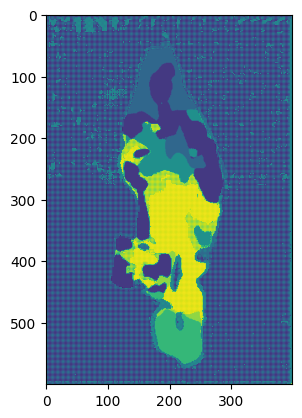

tensor([[[[2, 2, 2,  ..., 1, 1, 1],
          [2, 2, 2,  ..., 1, 1, 1],
          [2, 2, 2,  ..., 1, 1, 1],
          ...,
          [1, 1, 1,  ..., 0, 6, 0],
          [1, 1, 1,  ..., 0, 0, 0],
          [1, 1, 1,  ..., 0, 6, 0]]]], device='cuda:0')
tensor([[[[3., 3., 3.,  ..., 0., 0., 0.],
          [3., 3., 3.,  ..., 0., 0., 0.],
          [3., 3., 3.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 5., 5., 5.],
          [0., 0., 0.,  ..., 5., 5., 5.],
          [0., 0., 0.,  ..., 5., 5., 5.]]]], device='cuda:0')


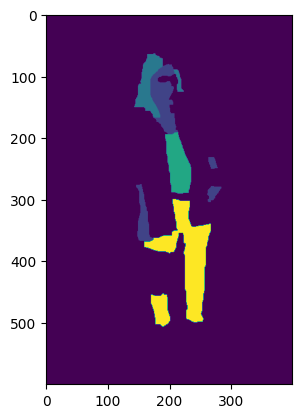

torch.Size([1, 1, 600, 400])


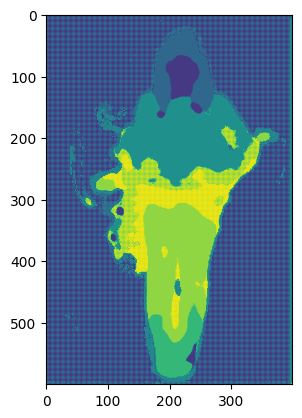

tensor([[[[3, 3, 3,  ..., 3, 3, 3],
          [3, 3, 3,  ..., 3, 3, 3],
          [3, 3, 3,  ..., 3, 3, 3],
          ...,
          [5, 5, 5,  ..., 5, 5, 5],
          [5, 5, 5,  ..., 5, 5, 5],
          [5, 5, 5,  ..., 5, 5, 5]]]], device='cuda:0')
tensor([[[[3., 3., 3.,  ..., 3., 3., 3.],
          [3., 3., 3.,  ..., 3., 3., 3.],
          [3., 3., 3.,  ..., 3., 3., 3.],
          ...,
          [5., 5., 5.,  ..., 5., 5., 5.],
          [5., 5., 5.,  ..., 5., 5., 5.],
          [5., 5., 5.,  ..., 5., 5., 5.]]]], device='cuda:0')


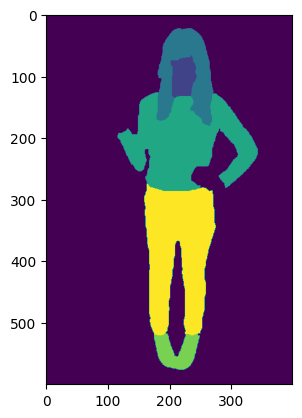

torch.Size([1, 1, 600, 400])


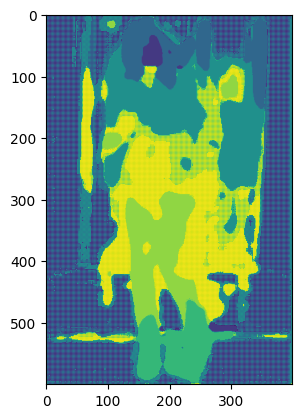

tensor([[[[6, 3, 6,  ..., 3, 6, 3],
          [6, 6, 6,  ..., 6, 6, 6],
          [6, 3, 6,  ..., 3, 6, 3],
          ...,
          [5, 5, 5,  ..., 6, 6, 6],
          [5, 5, 5,  ..., 5, 6, 5],
          [5, 5, 5,  ..., 6, 6, 6]]]], device='cuda:0')
tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [5., 5., 5.,  ..., 0., 0., 0.],
          [5., 5., 5.,  ..., 0., 0., 0.],
          [5., 5., 5.,  ..., 0., 0., 0.]]]], device='cuda:0')


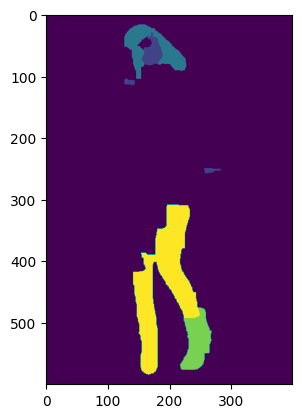

UnboundLocalError: local variable 'labels' referenced before assignment

In [ ]:
output, target = get_accuracy2(model, train_data_clothing)

<ipython-input-4-0304984a0bdf>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return (torch.tensor(img, dtype=torch.float32), torch.tensor(label, dtype=torch.float32))


torch.Size([1, 1, 600, 400])


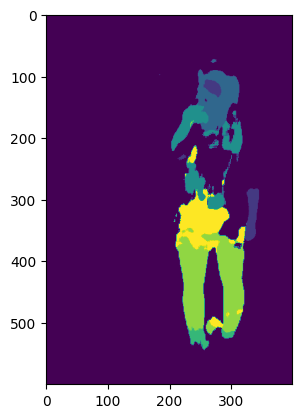

tensor([[[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 5, 5, 5],
          [0, 0, 0,  ..., 5, 5, 5],
          [0, 0, 0,  ..., 5, 5, 5]]]], device='cuda:0')
tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 5., 5., 5.],
          [0., 0., 0.,  ..., 5., 5., 5.],
          [0., 0., 0.,  ..., 5., 5., 5.]]]], device='cuda:0')


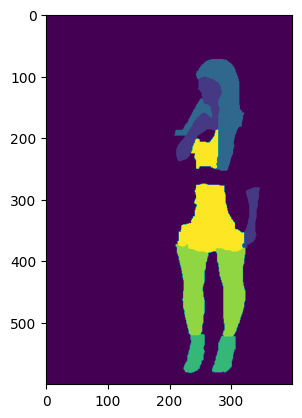

torch.Size([1, 1, 600, 400])


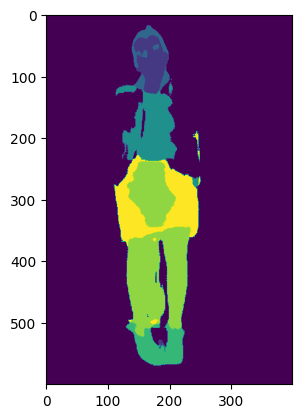

tensor([[[[3, 3, 3,  ..., 0, 0, 0],
          [3, 3, 0,  ..., 0, 0, 0],
          [3, 0, 0,  ..., 0, 0, 0],
          ...,
          [5, 5, 5,  ..., 0, 0, 0],
          [5, 5, 5,  ..., 0, 0, 0],
          [5, 5, 5,  ..., 0, 0, 0]]]], device='cuda:0')
tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:0')


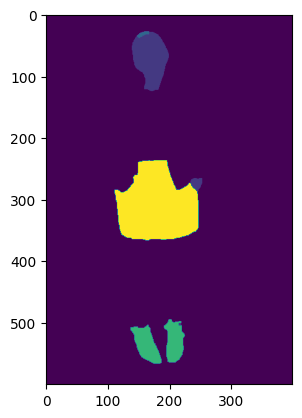

torch.Size([1, 1, 600, 400])


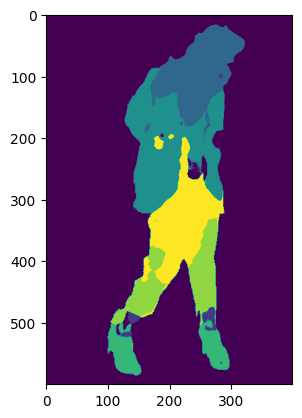

tensor([[[[6, 6, 6,  ..., 3, 3, 3],
          [6, 6, 6,  ..., 3, 3, 3],
          [6, 6, 6,  ..., 3, 3, 3],
          ...,
          [6, 6, 6,  ..., 5, 5, 5],
          [6, 6, 6,  ..., 5, 5, 5],
          [6, 6, 6,  ..., 5, 5, 5]]]], device='cuda:0')
tensor([[[[1., 1., 1.,  ..., 5., 5., 5.],
          [1., 1., 1.,  ..., 5., 5., 5.],
          [1., 1., 1.,  ..., 5., 5., 5.],
          ...,
          [5., 5., 5.,  ..., 5., 5., 5.],
          [5., 5., 5.,  ..., 5., 5., 5.],
          [5., 5., 5.,  ..., 5., 5., 5.]]]], device='cuda:0')


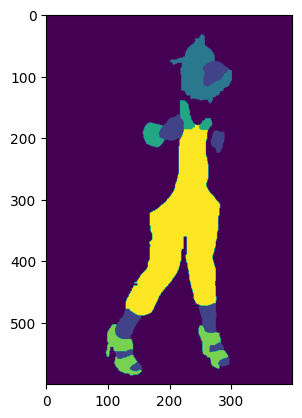

UnboundLocalError: local variable 'labels' referenced before assignment

In [ ]:
output, target = get_accuracy2(model, val_data_clothing)

In [ ]:
print(np.unique(output.cpu().numpy(), return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6]), array([213586,  13669,   7877,    509,   4153,    131,     75]))


In [ ]:
print(np.unique(target.cpu().numpy(), return_counts=True))

(array([0, 1, 2, 4]), array([220891,  12074,   3448,   3587]))


In [ ]:
import pickle

In [ ]:
filename = "/content/gdrive/MyDrive/CSC420_Final_Project/project3/project3/metrics/iters-1-1-2-4-dial-8-8-16-8-blocks-1-max.pkl"
with open(filename,"wb") as file:
  pickle.dump(iters, file)

In [ ]:
filename = "/content/gdrive/MyDrive/CSC420_Final_Project/project3/project3/metrics/epochs-1-1-2-4-dial-8-8-16-8-blocks-1-max.pkl"
with open(filename,"wb") as file:
  pickle.dump(epochs, file)


In [ ]:
filename = "/content/gdrive/MyDrive/CSC420_Final_Project/project3/project3/metrics/train_accs-1-1-2-4-1-max.pkl"
with open(filename,"wb") as file:
  pickle.dump(train_accs, file)

In [ ]:
filename = "/content/gdrive/MyDrive/CSC420_Final_Project/project3/project3/metrics/train_losses-1-1-2-4-dial-8-8-16-8-blocks-1-max.pkl"
with open(filename,"wb") as file:
  pickle.dump(train_losses, file)


In [ ]:
filename = "/content/gdrive/MyDrive/CSC420_Final_Project/project3/project3/metrics/val_accs-1-1-2-4-dial-8-8-16-8-blocks-1-max.pkl"
with open(filename,"wb") as file:
  pickle.dump(val_accs, file)

In [ ]:
filename = "/content/gdrive/MyDrive/CSC420_Final_Project/project3/project3/metrics/-1-1-2-4-dial-8-8-16-8-blocks-1-max.pkl"
with open(filename,"wb") as file:
  pickle.dump(val_ious, file)

In [ ]:
filename = "/content/gdrive/MyDrive/CSC420_Final_Project/project3/project3/metrics/train_ious-1-1-2-4-1-max.pkl"
with open(filename,"wb") as file:
  pickle.dump(train_ious, file)